
![Airbnb_logo.jpg](Images/Airbnb_logo.png)

# Milan Airbnb Recommender
Creating a recommendation system for individuals who have stayed previously at Milan Airbnb and are wishing to at a new one. 

By: Anat Jacobson 

--- 


# Contents [fixing this]
<l></l>

<span style="font-size:1.2em;">

- <a href="#Overview">Overview</a>

- <a href="#Introduction and Business Case">Introduction and Business Case</a>  

- <a href="#Business Understandings">Business Understandings</a> 
    - <a href="#Applications">Applications</a>
    
    - <a href="#Methodology">Methodology</a>
- <a href="##Data Exploration and Analysis">Data Exploration and Analysis</a>

- <a href="#Recommendation System">Recommendation System</a>
    
    - <a href="#Surprise Data">Surprise Data</a>
    
    - <a href="#Baselines">Baselines</a>
    
    - <a href="#SVD">SVD </a>
    
    - <a href="#NMF">NMF</a>
    
    - <a href="#SVD++">SVD++</a>
    
- <a href="#Recommendation Function">Recommendation Function</a>
       
- <a href="#Conclusion and Next Steps">Conclusion and Next Steps</a>

### Overview 

In this notebook I will be creating a recommedation system for Milan Airbnb users. This project is based on data from previous visitors and reviewers of Milan's airbnb. The data has been used to create a various recommendation models and provide valuable insight into whether an airbnb would be liked or recommended by an individual or not. This be extremely helpful for both guests and hosts when looking into where to stay next so that they could have a personalized experience that they could enjoy based on past experiences. 

### Introduction and Business Case

There are thousands of Airbnb options within Milan but each one comes with different perks and ammenities. With so many listings available on the airbnb platform, it can be overwhelming for guests to find the perfect accommodation for their needs. A recommendation system could analyze a user's previous bookings, preferences, and behaviors to suggest listings that are likely to meet their needs and exceed their expectations. By providing personalized recommendations, a recommendation system could enhance the user experience on Airbnb and increase customer satisfaction, ultimately leading to higher retention rates and revenue for the platform.

The data for this notebook has been provided by [Inside Airbnb: Milan](http://insideairbnb.com/milan")

### Business Understandings

#### Applications
- Airbnb users can make informed decisions when deciding which airbnb to rent next and have a great experience
- Airbnb itself will also benefit from users having more personalized expereience they would likely have higher retention and revenue rates when more customers are enjoying each airbnb stay. 

#### Data 
The dataset that was worked with after cleaning had over 45K reviews in it with data that focused on the datetime information of the review as well as information of of idententifying the listing iteself payment. The secondary dataset contained data on the ammenities of the listing as well as some helpful information on the host. 
- 18.6K Reviewers ranging from 2 reviews - 26
- 9.2K airbnbs across Milan
- Reviews span 12 years from 2011 - 2023
- Listing accomodations ranging from 1-16 people, on average accomodating 3 people


#### Methodology
The initial data being worked with did not containing a rating scale for how well liked the airbnb was by user. Because of this, I created a sentiment analysis score that took the sentiment of the comment and rated it between 1-10 on how much the user liked the airbnb. This score is what the recommendation system will be based off of.

---

## Data Exploration and Analysis
Importing all packages needed and creating function for opening zip file. 

In [807]:
#imports necessary downloads
import pandas as pd
import numpy as np
import pickle

#import detect for language dectection
!pip install langdetect
from langdetect import detect

#import sentiment analyzer 
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

#import vectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

#import matplot for graphing
import matplotlib.pyplot as plt
import matplotlib as mpl

#importing the necessary modules for suprise. 
from surprise.model_selection import cross_validate
from surprise import Dataset, Reader, accuracy
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anatjacobson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [579]:
#nltk.download()

## Import CSVs and Clean Data
<b> 2 Datasets imported: </b>
- reviews: contains all the reviews of the dataset, reviewer ID's, and listing IDs
- listings: contains all the features of the listings and the listing IDs.
    - For the purposes of this project, the listings data will only be used for comparisson purposes when looking at how features of recommended airbnbs for users compare to actual airbnbs a user has reviewed. For this reason, we will not be doing much cleaning on this dataset. 

Will be working with both of these dataframes to recommend the best user airbnbs! 

In order to import the revies csv, you must unzip the review zip file and then import the reviews.csv

In [580]:
#importing and saving the unzipped reviews file
reviews = pd.read_csv('Data/reviews.csv')

In [581]:
#importing and saving listings file
listings = pd.read_csv('Data/listings.csv')

**Focusing on only the reviews Dataframe until the latter half of the project**

<b> Reviews:

In [582]:
#checking the shape of the reviews dataframe
print('reviews shape: ', reviews.shape)

#looking at the first 5 rows of the dataframe 
display(reviews.head())


reviews shape:  (611804, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6400,36772,2010-04-19,94463,Hyun,I had such a great stay at 'the studio.' Fran...
1,6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...
2,6400,1162608,2012-04-22,415910,Tej,This is my second time staying with Francesca ...
3,6400,11670681,2014-04-11,8464658,Isabelle,"Ein wunderbares Zimmer mit privatem Bad/ WC, a..."
4,6400,11780336,2014-04-14,5427294,Hatice,"I was lucky so I have stayed with Francesca, A..."


In [583]:
#Running a count on the number of reviews
reviews['reviewer_id'].count()

611804

In [584]:
#showing a count of the number of unique reviewers
reviews['reviewer_id'].nunique()

547728

Checking out how many nulls we have. We mostly care about null comments since we will need to remove those. 

In [585]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611804 entries, 0 to 611803
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     611804 non-null  int64 
 1   id             611804 non-null  int64 
 2   date           611804 non-null  object
 3   reviewer_id    611804 non-null  int64 
 4   reviewer_name  611804 non-null  object
 5   comments       611777 non-null  object
dtypes: int64(3), object(3)
memory usage: 28.0+ MB


Not bad! We are going to drop rows with null comments now since a null comment is useless for our recommendation system. 

In [586]:
reviews = reviews.dropna()

#### Identifying our sample dataset
Below, will be doing  a groupby below to check how many reviews a given reviewer gives. Will then be checking top 50 sorting from greatest to least. 
- The reasoning behind this preliminary analysis is to see if there is enough data to run this recommendation system on for it to be statistically significant. If for example there were only 10 people who gave more than 1 review, this would be too small of a dataset to work with. 

In [587]:
#running the groupby
reviews.groupby('reviewer_id').count().sort_values('reviewer_name', ascending = False).head(50)

,listing_id,id,date,reviewer_name,comments
reviewer_id,,,,,
21546831,55,55,55,55,55
4458363,54,54,54,54,54
41371840,44,44,44,44,44
31058107,42,42,42,42,42
26149575,38,38,38,38,38
65479491,37,37,37,37,37
432993993,36,36,36,36,36
90675773,34,34,34,34,34
257621892,32,32,32,32,32


In [588]:
#saving this as its own df to continue analysis
group_df = reviews.groupby('reviewer_id').count()

In [589]:
#checking for all individuals that have more than 4 reviews. The more users the better!
group_df.loc[group_df['reviewer_name'] > 4] 

,listing_id,id,date,reviewer_name,comments
reviewer_id,,,,,
30054,6,6,6,6,6
31333,5,5,5,5,5
51871,7,7,7,7,7
153875,8,8,8,8,8
177094,5,5,5,5,5
...,...,...,...,...,...
487561278,6,6,6,6,6
488007125,5,5,5,5,5
489595940,7,7,7,7,7


This is a good amount of users! Lets see how many idividuals gave more than 1 review. 

In [590]:
#checking for more than 1 review
group_df.loc[group_df['reviewer_name'] > 1]

,listing_id,id,date,reviewer_name,comments
reviewer_id,,,,,
4891,2,2,2,2,2
5102,2,2,2,2,2
10918,2,2,2,2,2
15019,2,2,2,2,2
17637,2,2,2,2,2
...,...,...,...,...,...
502149046,2,2,2,2,2
502289079,2,2,2,2,2
502622705,2,2,2,2,2


This is a lot! We are going to try subsetting by reviews greater than 1 since we will still need to filter out non english reviews. The reason we need to look at reviewers with more than one review is for the system to recognize a pattern within these reviewers.

In [591]:
reviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6400,36772,2010-04-19,94463,Hyun,I had such a great stay at 'the studio.' Fran...
1,6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...
2,6400,1162608,2012-04-22,415910,Tej,This is my second time staying with Francesca ...
3,6400,11670681,2014-04-11,8464658,Isabelle,"Ein wunderbares Zimmer mit privatem Bad/ WC, a..."
4,6400,11780336,2014-04-14,5427294,Hatice,"I was lucky so I have stayed with Francesca, A..."


Grouping by reviewer_id shows up more than one time to work on the right dataframe for a rec system

In [592]:
#showing the reviewers and comments with those more than 1
reviews.groupby('reviewer_id').filter(lambda x : x['reviewer_id'].shape[0] > 1)

,listing_id,id,date,reviewer_id,reviewer_name,comments
1,6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...
2,6400,1162608,2012-04-22,415910,Tej,This is my second time staying with Francesca ...
3,6400,11670681,2014-04-11,8464658,Isabelle,"Ein wunderbares Zimmer mit privatem Bad/ WC, a..."
5,6400,30074708,2015-04-17,415910,Tej,Always a pleasure staying with Francesca and f...
6,6400,47340535,2015-09-18,5023643,Glynn,The host canceled this reservation the day bef...
...,...,...,...,...,...,...
611776,841733870641961371,846910401901382122,2023-03-14,88108605,Diego,en general el departamento está bien. pusieron...
611782,843618815888733815,846290934716632307,2023-03-13,223990220,Tare,Great place.<br/>Host was really helpful.<br/>...
611785,846130517363365733,849082404435780093,2023-03-17,35287167,Greta,"The apartment is in a very good location, just..."
611789,845609167593520388,849860891804052515,2023-03-18,144769793,Gina,Casa pulita e in ordine come da descrizione. S...


Below checking that this group by is working the way that it should.

In [593]:
reviews.groupby('reviewer_id').filter(lambda x : x['reviewer_id'].shape[0]== 1)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6400,36772,2010-04-19,94463,Hyun,I had such a great stay at 'the studio.' Fran...
4,6400,11780336,2014-04-14,5427294,Hatice,"I was lucky so I have stayed with Francesca, A..."
12,23986,1175194,2012-04-24,1695229,Leah,We came to Milan for the Salone and had a fant...
13,23986,47872586,2015-09-21,17316381,Paolo,La zona è molto comoda e la via è tranquilla. ...
14,23986,70176179,2016-04-16,41686521,Naama,"Great apartment, clean and well equipped, grea..."
...,...,...,...,...,...,...
611798,837619455066975304,848390146274753958,2023-03-16,416263051,Catalin,It was very good
611799,838184897759433339,847722747234842814,2023-03-15,46351960,Irina,Nice and quiet area not far from the metro and...
611801,838266422550245358,840401357243960792,2023-03-05,424155005,Riccardo,Ottimo
611802,838266422550245358,843313780914723751,2023-03-09,388259970,Mariana,It was really nice!


In [594]:
reviews.shape[0] - reviews['reviewer_id'].value_counts().shape[0]

64071

These 2 shapes add up to our number of rows in the full dataset so it looks like this worked! Below saving off a new dataframe with the values of individuals with more than 1 review since these are the users we will be creating the recommendation system off of.

In [595]:
multi_review_df = reviews.groupby('reviewer_id').filter(lambda x : x['reviewer_id'].shape[0]>=2)

In [596]:
multi_review_df.shape

(104478, 6)

In [597]:
multi_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104478 entries, 1 to 611800
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     104478 non-null  int64 
 1   id             104478 non-null  int64 
 2   date           104478 non-null  object
 3   reviewer_id    104478 non-null  int64 
 4   reviewer_name  104478 non-null  object
 5   comments       104478 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.6+ MB


#### Cleaning Dataset for useful comments
- Removing all "unhelpful comments" meaning those with just a "." or blank. 
- Removing all comments that are emojis
- Creating a new column for language and dropping non-english reviews.

Below dropping unhelpful comments such ones that just have a "."  or other errors. 

In [598]:
index_dash = multi_review_df[ multi_review_df['comments'].str.match('-')].index
multi_review_df.drop(index_dash, inplace=True)

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
multi_review_df['comments'] = multi_review_df['comments'].map(alphanumeric)

In [599]:
#checking new shape
multi_review_df.shape

(104446, 6)

Below creating a list for all errors in the comments so that they can be removed before doing a sentiment analysis on this. This referencing work from Alex Gastone https://github.com/alexgastone/AirbnbRecommend/tree/master. 

In [600]:
num_errors = 0
err = []

for index, row in multi_review_df.iterrows():
    try:
        language = detect(row['comments']) 
    except:
        num_errors += 1
        err.append(index)
        print("This row throws an error:", row['comments'], row['reviewer_id'])

This row throws an error: . 411328576
This row throws an error: . 150986893
This row throws an error: . 177834202
This row throws an error: . 108801133
This row throws an error: 👌🏼 365065866
This row throws an error: . 138992230
This row throws an error: . 387506618
This row throws an error: 👍 414052082
This row throws an error: 👌🏽👌🏽👌🏽 180910287
This row throws an error: . 252823048
This row throws an error: 👏🏻🖤 107217428
This row throws an error: . 77570749
This row throws an error: . 45430085
This row throws an error: . 364141470
This row throws an error: 👍 444913428
This row throws an error: . 271759168
This row throws an error: . 21116219
This row throws an error: ! 127554328
This row throws an error: . 144289574
This row throws an error: .......... 310193172
This row throws an error: :) 16912762
This row throws an error: ✅ 4458363
This row throws an error: . 307111100
This row throws an error: 👍 424176069
This row throws an error: ... 92084355
This row throws an error: . 313934
Th

This row throws an error: 👍 78922162
This row throws an error: 👍 63249326
This row throws an error: . 175981122
This row throws an error: 👍🏼 176039305
This row throws an error: .. 441531885
This row throws an error: .. 441531885
This row throws an error: . 173643266
This row throws an error: ⭐️⭐️⭐️⭐️⭐️ 358886112
This row throws an error: 🙏 389897131
This row throws an error: ………. 326189650
This row throws an error: ***** 11087090
This row throws an error: . 85174017
This row throws an error: . 317938542
This row throws an error: 👍🏻 470452858
This row throws an error: . 161613103
This row throws an error: . 161613103
This row throws an error: . 57520969
This row throws an error: … 163022285
This row throws an error: 🥰🥰 273023762
This row throws an error: . 79210893
This row throws an error: . 79210893
This row throws an error: . 307890015
This row throws an error: . 35801088
This row throws an error: . 35801088
This row throws an error: . 434338284
This row throws an error: . 68614312
T

To check if this code is running appropriately, running a .loc before on a few of the users who appeared in the list above.

In [601]:
multi_review_df.loc[multi_review_df['reviewer_id'] == 38359844]

,listing_id,id,date,reviewer_id,reviewer_name,comments
461821,38925364,462840186873751238,2021-09-30,38359844,Amerigo,👍👍👍👍👍👍👍👍
479065,41756100,615737979733279099,2022-04-29,38359844,Amerigo,Ho parlato con il marito. Molto gentile


Can see that the above reviewer did in fact have a comment that was all emojis! For now I will be dropping all these kinds of rows. At a later point I might try to convert emojis to text since they can be very valuable but for now will just be removing and moving on with my cleaning process. 


In [602]:
#Removing all non identifiable comments (the ones we got from code) and making new df
multi_review = multi_review_df.drop(err, axis=0)

In [603]:
#checking new dataframe shape and head
print(multi_review.shape)
display(multi_review.head())

(104124, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
1,6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...
2,6400,1162608,2012-04-22,415910,Tej,This is my second time staying with Francesca ...
3,6400,11670681,2014-04-11,8464658,Isabelle,"Ein wunderbares Zimmer mit privatem Bad/ WC, a..."
5,6400,30074708,2015-04-17,415910,Tej,Always a pleasure staying with Francesca and f...
6,6400,47340535,2015-09-18,5023643,Glynn,The host canceled this reservation the day bef...


In [605]:
len(err) #dropped 326 rows 

322

Checking individuals still have at least 2 reviews, if not will drop them.

In [607]:
multi_review.groupby('reviewer_id').filter(lambda x : x['reviewer_id'].shape[0] == 1).head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
11691,715392,711240566,2020-11-25,13753326,Massimo,"Appartamento confortevole e accogliente, con l..."
26350,1048855,102234877,2016-09-17,93702446,Ermes Fabrizio,"Ottima, buon quartiere"
40048,2035151,227540479,2018-01-15,89529924,Hagai,Great place and great value
46884,2221901,565327219,2019-11-17,275007113,光一郎,。
48805,2536806,237231594,2018-02-22,14256699,Lorenzo,La casa è un una posizione strategica per gira...


Will likely be dropping these in the following steps because they are not in english so will leave for now to save code. 

#### Detect
Using Detect library to capture what language the reviews are in so that the non english reviews can be dropped. Detect comes from langdetect and is using Googles languge detection library originally in Java. More information on this can be found [here](https://pypi.org/project/langdetect/)

Below, adding the column for what language the reviews are in and then dropping all non english reviews.

In [611]:
multi_review['language'] = multi_review['comments'].apply(detect)

In [612]:
#creating data frame with only english reviews
english_reviews = multi_review.loc[multi_review['language'] == 'en']

In [613]:
#showing new shape of dataframe
print(english_reviews.shape)
display(english_reviews.head())

(48739, 7)


,listing_id,id,date,reviewer_id,reviewer_name,comments,language
1,6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...,en
2,6400,1162608,2012-04-22,415910,Tej,This is my second time staying with Francesca ...,en
5,6400,30074708,2015-04-17,415910,Tej,Always a pleasure staying with Francesca and f...,en
6,6400,47340535,2015-09-18,5023643,Glynn,The host canceled this reservation the day bef...,en
7,6400,70088360,2016-04-16,415910,Tej,Another nice stay at Francesca's place.. I fee...,en


In [614]:
#checking there is more than one review for each person
english_reviews.groupby('reviewer_id').filter(lambda x : x['reviewer_id'].shape[0] == 1).head()


,listing_id,id,date,reviewer_id,reviewer_name,comments,language
23,23986,161250881,2017-06-17,134230425,Daniel,Jeremy was very communicative and has a great ...,en
333,304050,4134957,2013-04-13,2301725,Elena,Very good location in the city. From the cente...,en
444,304050,25392905,2015-01-14,22276765,Benjamin,Best hosts in town !!! Elena and her familly a...,en
561,434334,114544291,2016-11-19,85098831,Michela,Thank you it was realy a nice weekendtrip. The...,en
562,434334,114988553,2016-11-21,98885658,Jozef,The service provided was splendid. The apartme...,en


In [615]:
#updating dataframe to have multi-reviews in english
english_reviews = english_reviews.groupby('reviewer_id').filter(lambda x : x['reviewer_id'].shape[0] > 1)

In [616]:
english_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
1,6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...,en
2,6400,1162608,2012-04-22,415910,Tej,This is my second time staying with Francesca ...,en
5,6400,30074708,2015-04-17,415910,Tej,Always a pleasure staying with Francesca and f...,en
6,6400,47340535,2015-09-18,5023643,Glynn,The host canceled this reservation the day bef...,en
7,6400,70088360,2016-04-16,415910,Tej,Another nice stay at Francesca's place.. I fee...,en


In [617]:
english_reviews.shape

(45022, 7)

In [618]:
english_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45022 entries, 1 to 611800
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     45022 non-null  int64 
 1   id             45022 non-null  int64 
 2   date           45022 non-null  object
 3   reviewer_id    45022 non-null  int64 
 4   reviewer_name  45022 non-null  object
 5   comments       45022 non-null  object
 6   language       45022 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.7+ MB


### Sentiment Analyzer + Scoring
In order to create a recommendation system we will need to have some sort of rating system. in the given dataset we do not have any scores however we can create makeshift ratings based off of the sentiment of the given user. Below we will be instantiating a sentiment analyzer to create these scores and then using the polarity score to create a rating system of 1-10 of how the users comments (essentially) would be rating a given airbnb. This system and function has also been adapted from the previous work of Alex Gastone.

In [621]:
sia = SentimentIntensityAnalyzer()

In [622]:
#creating scores function on the analyzer
def scores(comment):
    score = sia.polarity_scores(comment)
    return(pd.DataFrame.from_dict(score, orient='index'))

In [623]:
#testing out how this works on the first review
scores(english_reviews['comments'][1])

,0
neg,0.0000
neu,0.5870
pos,0.4130
compound,0.9827


In [624]:
english_reviews['comments'][1]
#this makes sense that this is not considered a negative score!!

"Staying at Francesca's and Alberto's place was a pleasure. Just as described, well located for my purposes, an enjoyable walk to the Tortona area. The room is very nice, cleaned daily and has private bathroom.\r<br/>\r<br/>Francesca is super friendly and very helpful; whilst still respecting privacy.\r<br/>\r<br/>Overall a great experience!\r<br/>"

We are going to group our polarity scores 1-10 for recommendations and are going to be using just the positive scores for these recommendations. The reason we are using the positive scores is because these are the most accurate reflection of the what the sentiment of the comment is. For example, a positive score of 0 would be a comment that said "Horrible!" or "Host cancelled". Will see more of this below. 

 <b> Note </b> : We are keeping in cancelled reservations for this recommenders because I believe it says something about the host and listing as well if the reservations are often cancelled from a particular airbnb. 

In [625]:
polarity = lambda s: (sia.polarity_scores(s))['pos']
english_reviews['polarity'] = english_reviews.comments.map(polarity)

In [626]:
english_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
1,6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...,en,0.413
2,6400,1162608,2012-04-22,415910,Tej,This is my second time staying with Francesca ...,en,0.392
5,6400,30074708,2015-04-17,415910,Tej,Always a pleasure staying with Francesca and f...,en,0.112
6,6400,47340535,2015-09-18,5023643,Glynn,The host canceled this reservation the day bef...,en,0.000
7,6400,70088360,2016-04-16,415910,Tej,Another nice stay at Francesca's place.. I fee...,en,0.359


Binning the polarity scores 1-10 for the recommendation system

In [627]:
bins = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
labels = [1,2,3,4,5,6,7,8,9,10]

english_reviews['rec_scale'] = pd.cut(x = english_reviews['polarity'], bins = bins, labels = labels, include_lowest = True)

In [628]:
english_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity,rec_scale
1,6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...,en,0.413,5
2,6400,1162608,2012-04-22,415910,Tej,This is my second time staying with Francesca ...,en,0.392,4
5,6400,30074708,2015-04-17,415910,Tej,Always a pleasure staying with Francesca and f...,en,0.112,2
6,6400,47340535,2015-09-18,5023643,Glynn,The host canceled this reservation the day bef...,en,0.000,1
7,6400,70088360,2016-04-16,415910,Tej,Another nice stay at Francesca's place.. I fee...,en,0.359,4


In [806]:
english_reviews.loc[english_reviews['rec_scale'] == 10]['comments']

12370           Great!
12647         Perfect!
16012         Great!!!
20045     Recommended!
24211         Perfect!
              ...     
603129             top
604287           Great
606633             Top
607221             Top
610359             top
Name: comments, Length: 201, dtype: object

In [629]:
english_reviews['rec_scale'].value_counts()

4     10583
3     10104
5      7459
2      4970
6      4624
7      2653
1      2114
8      1677
9       637
10      201
Name: rec_scale, dtype: int64

In [630]:
english_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45022 entries, 1 to 611800
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   listing_id     45022 non-null  int64   
 1   id             45022 non-null  int64   
 2   date           45022 non-null  object  
 3   reviewer_id    45022 non-null  int64   
 4   reviewer_name  45022 non-null  object  
 5   comments       45022 non-null  object  
 6   language       45022 non-null  object  
 7   polarity       45022 non-null  float64 
 8   rec_scale      45022 non-null  category
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 4.4+ MB


In [631]:
english_reviews.loc[english_reviews['rec_scale'] == 1].head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity,rec_scale
6,6400,47340535,2015-09-18,5023643,Glynn,The host canceled this reservation the day bef...,en,0.000,1
9,6400,195594668,2017-09-20,30261686,Robin,The host canceled this reservation days befo...,en,0.000,1
56,37256,3380419,2013-01-20,4772989,Chantal,The reservation was canceled days before arr...,en,0.000,1
225,303469,462383734,2019-06-02,58141895,Aylin Sophie,I stayed months in this apartment during my ...,en,0.063,1
653,82227,460819058016140060,2021-09-27,158566202,Nigela,A nightmare host.. He made my life in the apar...,en,0.061,1


In [632]:
english_reviews.loc[english_reviews['rec_scale'] == 10].head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity,rec_scale
12370,737797,683816769264072426,2022-08-01,257561629,Danilo,Great!,en,1.0,10
12647,739252,491088217434016516,2021-11-08,245799912,Tarek,Perfect!,en,1.0,10
16012,713411,289306902,2018-07-12,3344712,Barbara,Great!!!,en,1.0,10
20045,996360,627318236624591458,2022-05-15,6562975,Nicolas,Recommended!,en,1.0,10
24211,918194,148577006,2017-05-01,33053175,Mauro,Perfect!,en,1.0,10


In [633]:
#checking for nulls
english_reviews.isnull().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
language         0
polarity         0
rec_scale        0
dtype: int64

There are no nulls, for now will be stopping with the cleaning of the data. If wanting to go further, I will make a vectorizer to remove stopwards and more accurately rate and scale. For now, I will continue to preliminary graphs and analysis. 

### Preliminary Graphs for Recommendation System
Creating some prelimanry graphs to understand the makeup of the data we will be making the reccomendation system off of. 

<b> Graphing users with the most reviews for milan airbnbs

In [634]:
#making dataframe of the top 10 users
top_10_reviewers = pd.DataFrame(english_reviews["reviewer_id"].value_counts(ascending=False).head(10))

#resetting index
top_10_reviewers = top_10_reviewers.reset_index()

#renaming columns based on value_counts
top_10_reviewers = top_10_reviewers.rename(columns={"reviewer_id":"review_count"})
top_10_reviewers = top_10_reviewers.rename(columns={"index":"reviewer_id"})

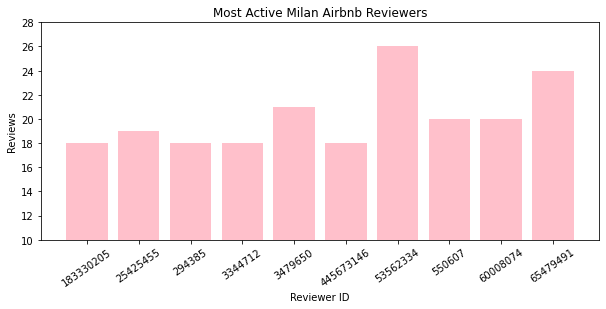

In [721]:
#making user_id a string for graphing
top_10_reviewers['reviewer_id'] = top_10_reviewers['reviewer_id'].astype(str)
#making sorted df for chart
top_10_sorted = top_10_reviewers.sort_values('review_count')
#making airbnb_rating a string
grouped = top_10_sorted.groupby("reviewer_id")["review_count"].sum()
fig = plt.figure(figsize = (10, 4))
# create a bar plot
plt.bar(grouped.index, grouped.values, color="pink")
# set the x-axis label
plt.xlabel("Reviewer ID")
plt.xticks(rotation=35)

# set the y-axis label
plt.ylabel("Reviews")
plt.ylim(10, 28)

#adding title
plt.title("Most Active Milan Airbnb Reviewers")

#saving image
plt.savefig('Images/active_reviewers.png', dpi=300, bbox_inches='tight')
# show the plot
plt.show()

In [671]:
#making dataframe of review counts to compare distribution of reviews
top_ratings = pd.DataFrame(english_reviews["rec_scale"].value_counts(ascending=False).head(10))
top_ratings = top_ratings.reset_index()
top_ratings = top_ratings.rename(columns={"rec_scale":"Rec_Count"})
top_ratings = top_ratings.rename(columns={"index":"Rec_Number"})

#making user_id a string for plotting
top_ratings['Rec_Count'] = top_ratings['Rec_Count'].astype(int)
top_ratings.sort_values(by = 'Rec_Count', axis = 0, inplace = True)
top_ratings

,Rec_Number,Rec_Count
9,10,201
8,9,637
7,8,1677
6,1,2114
5,7,2653
4,6,4624
3,2,4970
2,5,7459
1,3,10104
0,4,10583


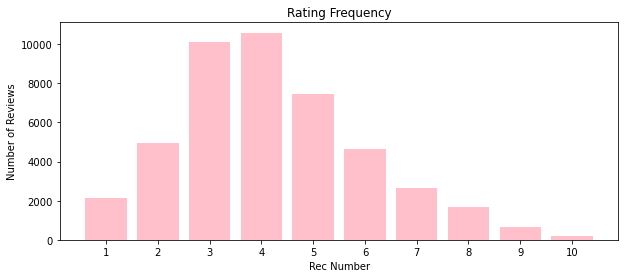

In [718]:
#making scatter plot of rating frequency
fig = plt.figure(figsize = (10, 4))

#create a bar plot
plt.bar(top_ratings['Rec_Number'], top_ratings['Rec_Count'], color="pink")

# set the x-axis
plt.xlabel("Rec Number")
plt.xticks(top_ratings['Rec_Number'])

#set the y-axis
plt.ylabel("Number of Reviews")
plt.yticks()

#adding title
plt.title("Rating Frequency")
#saving image
plt.savefig('Images/rating_frequency.png', dpi=300, bbox_inches='tight')

# show the plot
plt.show()



In [788]:
top_ratings.sort_values(by = 'Rec_Number')

,Rec_Number,Rec_Count
6,1,2114
3,2,4970
1,3,10104
0,4,10583
2,5,7459
4,6,4624
5,7,2653
7,8,1677
8,9,637
9,10,201


## Recommendation System
Export smaller Dataframe english reviews for ease of loading back in. 

In [118]:
english_reviews.to_csv(r'C:\Users\anatjacobson\Documents\Flatiron\Projects\Capstone\english_reviews.csv', index=False, header=True)

#print(english_reviews)

In [193]:
#final_df = pd.read_csv('english_reviews.csv')

In [244]:
final_df=english_reviews

Commmented out as to not keep exporting.

In [245]:
final_df.shape

(45002, 9)

In [701]:
final_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity,rec_scale
1,6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...,en,0.413,5
2,6400,1162608,2012-04-22,415910,Tej,This is my second time staying with Francesca ...,en,0.392,4
5,6400,30074708,2015-04-17,415910,Tej,Always a pleasure staying with Francesca and f...,en,0.112,2
6,6400,47340535,2015-09-18,5023643,Glynn,The host canceled this reservation the day bef...,en,0.000,1
7,6400,70088360,2016-04-16,415910,Tej,Another nice stay at Francesca's place.. I fee...,en,0.359,4


In [702]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45002 entries, 1 to 611800
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   listing_id     45002 non-null  int64   
 1   id             45002 non-null  int64   
 2   date           45002 non-null  object  
 3   reviewer_id    45002 non-null  int64   
 4   reviewer_name  45002 non-null  object  
 5   comments       45002 non-null  object  
 6   language       45002 non-null  object  
 7   polarity       45002 non-null  float64 
 8   rec_scale      45002 non-null  category
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 4.4+ MB



#### Surprise Data

To make my airbnb recommendation model, I will be using the Suprise library in python that focuses on building recommendation stystems. It uses various methods and provides evaluations on the systems. Below we will be using this library to implement SVD, SVD++ and NMF for a collaborative based filtering system. In order to begin using this system we will be making a new dataframe with just Reviewer ID, rec_scale, and listing ID from our final english reviews dataframe. The reason we are doing this is because suprise is a matrix factorization-based system so only takes in a certain number of columns necessary. 

In [388]:
#dropping columns that aren't needed for Surprise
surprise_df = final_df.drop(columns=["id", "date", "reviewer_name", "comments", "language",
                                    "polarity"])

In [389]:
surprise_df.head()

,listing_id,reviewer_id,rec_scale
1,6400,415910,5
2,6400,415910,4
5,6400,415910,2
6,6400,5023643,1
7,6400,415910,4


In [390]:
#changing the order to reviewer, listing id, rec_scale since this is needed to run appropriately.
surprise_df = surprise_df[['reviewer_id', 'listing_id', 'rec_scale']]
surprise_df.head()

,reviewer_id,listing_id,rec_scale
1,415910,6400,5
2,415910,6400,4
5,415910,6400,2
6,5023643,6400,1
7,415910,6400,4


In [391]:
surprise_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45002 entries, 1 to 611800
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   reviewer_id  45002 non-null  int64   
 1   listing_id   45002 non-null  int64   
 2   rec_scale    45002 non-null  category
dtypes: category(1), int64(2)
memory usage: 2.3 MB


In [392]:
surprise_df.isnull().sum()

reviewer_id    0
listing_id     0
rec_scale      0
dtype: int64

In [394]:
from surprise import Reader, Dataset

#loading into reader with the scale used from vader
reader = Reader(rating_scale=(1, 10))

#loading into final dataset
data = Dataset.load_from_df(surprise_df, reader)

#spltting into train and test groups
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [395]:
#looking at number of users
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items)

Number of users:  18062 

Number of items:  8561


#### Baseline Model
This represents true baseline

In [396]:
# Instantiate the model
baseline = NormalPredictor()

#fitting model
baseline.fit(trainset)

# making prediction on testset
predictions = baseline.test(testset)

# Save RMSE score
baseline_normal = accuracy.rmse(predictions)

RMSE: 2.5176


In [397]:
baseline_normal

2.517649427206763

Normal Predictor baseline model's RMSE (Root Mean Squared Error) is telling us that our predicted rating of airbnb recommendors is ~2.5 points away from the actual rating. 

#### Baseline Only
Below I am running a baseline only to see if can decrease the RMSE.

In [467]:
# Instantiate and fit model
baseline_only_model = BaselineOnly()

#fitting model
baseline_only_model.fit(trainset)

# making prediction on testset
predictions = baseline_only_model.test(testset)

# Save RMSE score
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.7633


In [468]:
baseline_only

1.7632575496836642

We decreased the RMSE somewhat substatially with this baseline only method. Below we will be running a few more complex models to see if we can decrease further. 

### Singular Value Decomposition
SVD (Singular Value Decomposition) is used to reduce the dimensionality of our matrix. SVD is a matrix factorization model that decomposes the reviewer reviews and airbnb listings into three matrices and helps us understand the relationship between users and items.

#### SVD Model 1
In this first model we will be using normal metrics as a base and see how the model runs! 

In [399]:
# Cross validate a basic SVD with no hyperparameter

svd_1 = SVD(random_state=42)

results = cross_validate(svd_1, data, measures=['RMSE'], cv=3, n_jobs = -3, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.7447  1.7686  1.7713  1.7615  0.0120  
Fit time          1.38    1.37    1.37    1.37    0.00    
Test time         0.07    0.07    0.07    0.07    0.00    


In [469]:
# Fit to trainset and predict on the testset for evaluation
svd_1.fit(trainset)

predictions1 = svd_1.test(testset)

svd_simple = accuracy.rmse(predictions1)

RMSE: 1.7527


The RMSE for the model did decrease, however not by very much. Will keep iterating on models to attempt more accurate predictions.

#### SVD GS Model 1
- Performing a grid search below to find best hyper parameters for model with lowest RMSE
- Including default parameters within the grid search as well

In [455]:
#test grid search
params = {'n_factors': [10, 50, 100, 150, 200],
          'n_epochs': [10, 20],
          'init_mean': [-0.5, 0, 0.5], 
          'reg_all': [.05, 0.02],
         'biased': [True, False]}

g_s_svd1 = GridSearchCV(SVD, param_grid=params, cv=5, joblib_verbose= 3, n_jobs= -3, refit=True)

g_s_svd1.fit(data)
g_s_svd1.best_params['rmse']


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-3)]: Done 116 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-3)]: Done 276 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-3)]: Done 500 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-3)]: Done 600 out of 600 | elapsed:  3.6min finished


{'n_factors': 50,
 'n_epochs': 20,
 'init_mean': 0,
 'reg_all': 0.05,
 'biased': True}

In [456]:
print(g_s_svd1.best_score['rmse'])
print(g_s_svd1.best_params['rmse'])

1.7545315942796509
{'n_factors': 50, 'n_epochs': 20, 'init_mean': 0, 'reg_all': 0.05, 'biased': True}


In [457]:
# instantiating SVD with best hyperparameters from gridsearch
g_s_svd1 = SVD(n_factors=50,n_epochs=20, init_mean=0, reg_all=0.05, biased=True)

# fit on trainset and make predictions using testset
g_s_svd1.fit(trainset)
predictions1 = g_s_svd1.test(testset)
g_s_svd_1 = accuracy.rmse(predictions1)

RMSE: 1.7517


In [458]:
#saving test rmse for final graph
test_g_s_svd_1_params = {'n_factors': 50,'n_epochs': 20,'init_mean': 0,'reg_all': 0.05, 'biased': True}
test_g_s_svd_1_rmse = 1.7517

In [124]:
#from joblib import dump, load

In [115]:
#dump(g_s_svd,"./data/model.pkl")

['./data/model.pkl']

This maxed out all our parameters so going to change and increase/decrease for following grid searches.

#### SVD GS Model 2
Running another grid search changing parameters based on results from previous. 

In [460]:
params = {'n_factors': [5, 10, 20, 30, 40, 50, 60],
          'n_epochs': [10, 15, 20, 25],
           'init_mean': [0, 0.5, 0.8], 
           'reg_all': [.05, 0.02, .01, .03],
           'biased': [True, False]}

g_s_svd2 = GridSearchCV(SVD, param_grid=params, cv=5, refit=True, joblib_verbose= 3, n_jobs = -3)

g_s_svd2.fit(data)
g_s_svd2.best_params['rmse']

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-3)]: Done 116 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-3)]: Done 276 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-3)]: Done 500 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-3)]: Done 788 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-3)]: Done 1140 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-3)]: Done 1556 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-3)]: Done 2036 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-3)]: Done 2580 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-3)]: Done 3188 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-3)]: Done 3360 out of 3360 | elapsed: 11.1min finished


{'n_factors': 40,
 'n_epochs': 25,
 'init_mean': 0,
 'reg_all': 0.05,
 'biased': True}

In [466]:
print(g_s_svd2.best_score['rmse'])
print(g_s_svd2.best_params['rmse'])

1.7480341779181565
{'n_factors': 40, 'n_epochs': 25, 'init_mean': 0, 'reg_all': 0.05, 'biased': True}


In [470]:
# instantiating SVD with best hyperparameters from gridsearch
g_s_svd2 = SVD(n_factors=60,n_epochs=25, init_mean=0,  reg_all=0.05, biased=True)

# fit on trainset and make predictions using testset
g_s_svd2.fit(trainset)
predictions2 = g_s_svd2.test(testset)
g_s_svd_2 = accuracy.rmse(predictions2)

RMSE: 1.7497


In [471]:
#saving test rmse for final graph
test_g_s_svd_2_params = {'n_factors':60,'n_epochs': 25,'init_mean': 0,'reg_all': 0.05, 'biased': True}
test_g_s_svd_2_rmse = 1.7497

#### SVD GS Model 3
Running a third grid search attempting to tune further based on previous results. 

In [132]:
params = {'n_factors': [5, 8, 10, 50, 60],
          'n_epochs': [20, 25, 30, 40, 50, 60],
          'reg_all': [.05, .02, .03]}

g_s_svd3 = GridSearchCV(SVD, param_grid=params, cv=5, refit=True, joblib_verbose= 3, n_jobs = -3)

g_s_svd3.fit(data)
g_s_svd3.best_params['rmse']

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-3)]: Done 116 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-3)]: Done 276 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-3)]: Done 450 out of 450 | elapsed:  2.5min finished


{'n_factors': 5, 'n_epochs': 40, 'reg_all': 0.05}

In [133]:
print(g_s_svd3.best_score['rmse'])
print(g_s_svd3.best_params['rmse'])

1.7464408802967835
{'n_factors': 5, 'n_epochs': 40, 'reg_all': 0.05}


In [472]:
# instantiating SVD with best hyperparameters from gridsearch
g_s_svd3 = SVD(n_factors= 5,n_epochs=40,  reg_all=0.05)

# fit on trainset and make predictions using testset
g_s_svd3.fit(trainset)
predictions3 = g_s_svd3.test(testset)
g_s_svd_3 = accuracy.rmse(predictions3)

RMSE: 1.7460


In [473]:
#saving test rmse for final graph
test_g_s_svd_3_params = {'n_factors':5,'n_epochs': 40,'reg_all': 0.05}
test_g_s_svd_3_rmse = 1.7460

Going to stop now running searches on SVD and move to another model to see if this performs better.

## Non-negative Matrix Factorization Model

Non-negative Matrix Factorization (NMF) is a technique that reduces dimensionality for non-negative matrices. It is particularly useful when dealing with non-negative and additive data and is often used for recommendation systems. Below I am attempting an NMF Model to see if this will produce a better RMSE for our recommendation system. 

#### <b> NMF Simple </b>
model without tuning hyperparameters

In [474]:
nmf_1 = NMF(random_state=42)

results = cross_validate(nmf_1, data, measures=['RMSE'], cv=3, n_jobs = -3, verbose=3, return_train_measures = True)

Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.0150  1.9987  2.0185  2.0107  0.0086  
RMSE (trainset)   0.4292  0.4436  0.4403  0.4377  0.0062  
Fit time          2.65    2.65    2.59    2.63    0.03    
Test time         0.06    0.06    0.06    0.06    0.00    


In [475]:
# Fit to trainset and predict on the testset for evaluation
nmf_1.fit(trainset)

predictions1 = nmf_1.test(testset)

nmf_simple = accuracy.rmse(predictions1)

RMSE: 2.0672


This RMSE is much higher than our scores from SVD, however I will attempt one grid search to see if this could be improved, will then move on to other methods of modeling. 

<b> NMF GS Model 1

In [141]:
# New hyperparameter dictionary for nmf model
nmf_param_grid = {'biased':[True, False],
                  'n_factors':[5, 10, 15, 20, 30, 40],
                  'n_epochs': [20, 25, 40, 50, 60, 70]}
nmf_gs_model1 = GridSearchCV(NMF, param_grid=nmf_param_grid, cv=3, joblib_verbose=3, n_jobs= -3, return_train_measures=True)

# Fit and return the best hyperparameters
nmf_gs_model1.fit(data)
nmf_gs_model1.best_params['rmse']

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-3)]: Done 116 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-3)]: Done 216 out of 216 | elapsed:  2.5min finished


{'biased': True, 'n_factors': 15, 'n_epochs': 20}

In [142]:
nmf_gs_model1.best_score['rmse']

1.8200447044015189

In [143]:
#saving params and best rmse
nmf_gs_model_best_params1 = {'biased': True, 'n_factors': 15, 'n_epochs': 20}
nmf_gs_model_rmse1 = 1.8200447044015189

In [476]:
# instantiating NFM
nfm_model1 = NMF(biased=True, n_factors=15, n_epochs=20)

# Fit on trainset and make predictions using testset to return RMSE metric
nfm_model1.fit(trainset)
predictions = nfm_model1.test(testset)
nfm_model_1 = accuracy.rmse(predictions)

RMSE: 1.8299


In [477]:
#saving test nfm model rmse for final graph
test_nfm_model_1_params = {'biased': True, 'n_factors': 10, 'n_epochs': 20}
test_nfm_model_1_rmse = 1.8299

This NMF model did not reduce much, even with first grid search. Because of this, I will be moving on to look at another modeling type -- SVD++. 

## Singular Value Decomposition++ Model
SVD++ is an enhanced version for SVD alogrithm. It incorporates implicit feedback which captures user preferences in a better way. This often makes SVD++ a more accurate system which is why it is very popular amongst the collaborative filtering-based recommender systems. 


#### SVD++ Model 1

In [480]:
#Running without tuning first
svdpp_1 = SVDpp()

results_svdpp = cross_validate(svdpp_1, data, measures=['RMSE'], cv=3, n_jobs = -3, verbose=True)

Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.7550  1.7582  1.7577  1.7570  0.0014  
Fit time          2.17    2.11    2.15    2.14    0.02    
Test time         0.11    0.12    0.11    0.11    0.00    


In [483]:
svdpp_1.fit(trainset)

predictions = svdpp_1.test(testset)

svdpp_simple = accuracy.rmse(predictions1)

RMSE: 2.0672


#### SVD++ GS Model 1
Testing out grid search below to see if we can improve with tuning. 

In [147]:
#using the best parameters from SVD and default parameters
params = {'n_factors': [4, 5, 8, 10, 20, 25],
          'n_epochs': [10, 20, 30, 40, 50, 60],
          'reg_all': [.05, .02, .01, .03]}

g_s_svdpp1 = GridSearchCV(SVDpp, param_grid=params, cv=5, refit=True, joblib_verbose= 3, n_jobs = -3)

g_s_svdpp1.fit(data)
g_s_svdpp1.best_params['rmse']

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-3)]: Done 116 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-3)]: Done 276 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-3)]: Done 500 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-3)]: Done 720 out of 720 | elapsed: 13.9min finished


{'n_factors': 4, 'n_epochs': 30, 'reg_all': 0.05}

In [149]:
print(g_s_svdpp1.best_score['rmse'])
print(g_s_svdpp1.best_params['rmse'])

1.7463650910665585
{'n_factors': 4, 'n_epochs': 30, 'reg_all': 0.05}


In [482]:
# instantiating SVD with best hyperparameters from gridsearch
g_s_svdpp1 = SVDpp(n_factors=4,n_epochs=30,  reg_all=0.05)

# fit on trainset and make predictions using testset
g_s_svdpp1.fit(trainset)
predictions = g_s_svdpp1.test(testset)
g_s_svdpp1 = accuracy.rmse(predictions)

RMSE: 1.7473


SVD++ provided the best model, will be stopping our iterations and continuing with the recommendation model from here. Will continue iterating if there is time at a later point but the for the purposes of this project we will be using svdpp1 as our best model. 

## Model Comparissons & Best Model

In [502]:
#X = ['Baseline Only', 'SVD Basic', 'NMF Basic ', 'SVDpp Basic',
  #   'Baseline Normal',  'SVD GS1', 'SVD GS2', 
  #   'SVD GS3', 'NMF GS',  'SVDpp GS']
#
#y = [baseline_only, svd_simple, nmf_simple ,svdpp_simple, baseline_normal, test_g_s_svd_1_rmse,
#     test_g_s_svd_2_rmse, test_g_s_svd_3_rmse, 
   #  nfm_model_1, g_s_svdpp1]

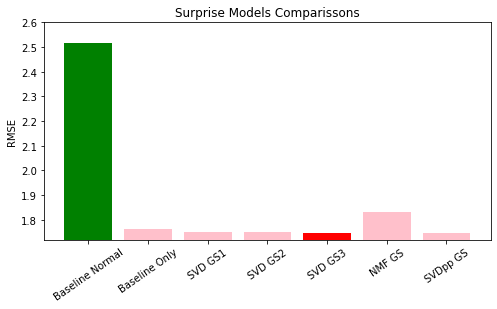

In [725]:
X = ['Baseline Normal', 'Baseline Only',  'SVD GS1', 'SVD GS2', 
     'SVD GS3', 'NMF GS',  'SVDpp GS']

y = [baseline_normal, baseline_only, test_g_s_svd_1_rmse,
     test_g_s_svd_2_rmse, test_g_s_svd_3_rmse, 
    nfm_model_1, g_s_svdpp1]

fig = plt.figure(figsize = (8, 4))
plt.bar(X, y, color=['green', 'pink', 'pink', 'pink', 'red', 'pink', 'pink', 'pink', 'pink'])
plt.xticks(rotation=35)
plt.ylim(1.72, 2.6)
plt.grid(False)
plt.title("Surprise Models Comparissons")
plt.ylabel('RMSE')
plt.savefig('Images/Model_bar.png', dpi=300, bbox_inches='tight')
plt.show()

In [728]:
X

['Baseline Normal',
 'Baseline Only',
 'SVD GS1',
 'SVD GS2',
 'SVD GS3',
 'NMF GS',
 'SVDpp GS']

I have iterated through the process and have stopped and picked my best model which is SVDGS3. This is a collaborative filtering method that identifies relationship between users airbnb ratings to make personzlied recommendations for users, based on their previous comments on other airbnbs.

My best model was the final SVD Grid Search that gave us a RMSE of 1.746.

- n_factors = 5
- reg_all = .05
- n_epochs = 40

These hyperparameters mean:
- n_factors are the number of factors that were used in this model to infer similarity and provide a recommendation. The default for this package is 100.
- reg_all is the regularization term for all the parameters.
- n_epochs are the number of iteration of the SGD (stochastic gradient descent), default being 20. 

For more information see suprise documentation [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)


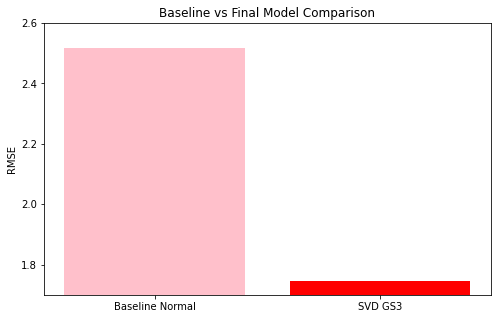

In [709]:
#Normal Compared to Final
X = ['Baseline Normal', 'SVD GS3']

y = [baseline_normal, test_g_s_svd_3_rmse]

fig = plt.figure(figsize = (8, 5))
plt.bar(X, y, color=['pink', 'red'])
plt.ylim(1.7, 2.6)
plt.grid(False)
plt.title("Baseline vs Final Model Comparison")
plt.ylabel('RMSE')
plt.savefig('Images/baseline.png', dpi=300, bbox_inches='tight')
plt.show()


The graph above shows how the SVD model compares to our baseline. Although it might not seem like such a large gap in RMSE, this is saying that our best model has and RMSE of 1.746 while our baseline normal is over 2.5. This is a large difference when understanding what these scores are. Our baseline normal predicts on average a rating around 2.5 points away from the actual while the best model predicts around 1.7 points away which is an increase of over 40% in prediction accuracy. -- normal predictor using distribution of ratings

In [528]:
#renaming and running the best model
best_model = SVD(n_factors=5,n_epochs=40,  reg_all=0.05)

In [529]:
best_model.fit(trainset)
predictions = best_model.test(testset)
accuracy_best_model = accuracy.rmse(predictions)

RMSE: 1.7467


In [530]:
best_model_params = {'n_factors':5,'n_epochs': 40,'reg_all': 0.05}
best_model_rmse = 1.7467

In [531]:
# Building full trainset in order to make predictions
full_trainset = data.build_full_trainset()
best_model.fit(full_trainset)

In [824]:
#saving model for streamlit
pickle.dump(best_model, open('model.sav', 'wb'))

--- 
## Recommendation Function

- Producing a function that spits out our predictions for recommended airbnbs based on the user. This function has been adapted from Daniel Burdeno's recommendation function from his capstone project linked [here](https://github.com/danielburdeno/Kindle-eBook-Recommendations/blob/main/CollaborativeFiltering.ipynb)
- Cleaning and doing some analysis on the listing dataset in order to use the dataframe for comparitive purposes when recieving recommendations. This way, when a user enters his/her ID, he/she can see what features the recommeded airbnb offers as well.

Cleaning a bit of the listing dataframe imported at the begining of this notebook

In [730]:
#dropping all columns that will not be relevant for the purposes of this project
listings.drop(columns = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url',
                        'host_id',  'license', 'calculated_host_listings_count_shared_rooms',
                        'calculated_host_listings_count_entire_homes', 'reviews_per_month',
                        'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count',
                        'first_review', 'last_review', 'host_since', 'host_url', 'minimum_nights',
                        'minimum_minimum_nights', 'maximum_maximum_nights', 'minimum_maximum_nights',
                         'maximum_nights_avg_ntm', 'minimum_nights_avg_ntm', 'longitude', 'latitude',
                        'bathrooms', 'calendar_updated', 'availability_30', 'availability_60',
                        'availability_90', 'availability_365', 'neighbourhood_group_cleansed',
                        'neighbourhood', 'has_availability', 'bathrooms_text', 'host_about',
                        'host_thumbnail_url', 'host_picture_url', 'maximum_minimum_nights',
                        'maximum_nights', 'price', 'host_has_profile_pic', 'host_listings_count',
                        'host_neighbourhood', 'host_verifications', 'host_total_listings_count',
                        'number_of_reviews_l30d', 'number_of_reviews_ltm', 'calendar_last_scraped',
                        'number_of_reviews'], 
              
              
              inplace = True)

In [731]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20370 entries, 0 to 20369
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           20370 non-null  int64  
 1   name                         20363 non-null  object 
 2   description                  19991 non-null  object 
 3   neighborhood_overview        11182 non-null  object 
 4   host_name                    20370 non-null  object 
 5   host_location                16839 non-null  object 
 6   host_response_time           15273 non-null  object 
 7   host_response_rate           15273 non-null  object 
 8   host_acceptance_rate         16552 non-null  object 
 9   host_is_superhost            20370 non-null  object 
 10  host_identity_verified       20370 non-null  object 
 11  neighbourhood_cleansed       20370 non-null  object 
 12  property_type                20370 non-null  object 
 13  room_type       

In [732]:
listings.isnull().sum()

id                                0
name                              7
description                     379
neighborhood_overview          9188
host_name                         0
host_location                  3531
host_response_time             5097
host_response_rate             5097
host_acceptance_rate           3818
host_is_superhost                 0
host_identity_verified            0
neighbourhood_cleansed            0
property_type                     0
room_type                         0
accommodates                      0
bedrooms                       1446
beds                            279
amenities                         0
review_scores_rating           4325
review_scores_accuracy         4496
review_scores_cleanliness      4496
review_scores_checkin          4497
review_scores_communication    4495
review_scores_location         4497
review_scores_value            4497
instant_bookable                  0
dtype: int64

Since we are only using this dataset for content purposes, I will not be dropping nulls since I only care about nulls within the listing ID. For comparative purposes, if the neighborhood is missing for some of these listings it is ok for now. 

In [733]:
#renaming id column in listing to be more clear
listings.rename(columns={"id": "listing_id"}, inplace=True)

In [734]:
final_df['listing_id'].unique().shape

(9274,)

In [735]:
#checking all listings in dataframe from reviews are in listing dataframe
print(set(final_df['listing_id']) in set(listings['listing_id']))

print(english_reviews['listing_id'].isin(set(listings['listing_id'])).unique())

print(english_reviews['listing_id'].isin(listings['listing_id']).unique())

False
[ True]
[ True]


In [822]:
#exporting for streamlit
final_df_export = final_df.copy()

In [821]:
final_df_export.to_csv('Data/final_df_export.csv')

In [818]:
#export listings dataframe for streamlit
export_listings = listings.drop(columns = ['property_type', 'neighbourhood_cleansed', 'neighborhood_overview',
                                'host_identity_verified', 'neighborhood_overview', 'name',
                                'host_location', 'host_name', 'host_response_rate', 'host_acceptance_rate', 
                                'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
                                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                                 'review_scores_value', 'beds'])
export_listings.head()

,listing_id,description,host_response_time,host_is_superhost,room_type,accommodates,bedrooms,amenities,instant_bookable
0,5678774,"A very nice flat in the city center, really go...",NaN,f,Entire home/apt,4,1.0,"[""Wifi"", ""Hot water"", ""Washer"", ""Iron"", ""TV wi...",f
1,5625937,T,within an hour,f,Entire home/apt,4,1.0,"[""TV"", ""Wifi"", ""Hot water"", ""Washer"", ""Iron"", ...",t
2,6139798,Affittasi casa periodo estivo. Vicinissima a E...,NaN,f,Entire home/apt,2,1.0,"[""TV with standard cable"", ""Washer"", ""Essentia...",t
3,7479570,Fully equipped house in the historical center ...,NaN,f,Entire home/apt,4,1.0,"[""Washer"", ""Essentials"", ""Elevator"", ""Kitchen""...",f
4,8438872,Very close to the Central Train Station and me...,NaN,f,Private room,2,1.0,"[""TV"", ""Washer"", ""Iron"", ""Hair dryer"", ""Essent...",f


In [823]:
#saving as export
export_listings.to_csv('Data/export_listings.csv')

#### Reviewer Dataframe for Function

In [736]:
#saving new dataframe with only user information for the purposes of function creation
reviewer_df = surprise_df.reset_index()
reviewer_df.set_index('reviewer_id', inplace = True)
reviewer_df.drop(columns = 'rec_scale', inplace =True)
reviewer_df.head()

,index,listing_id
reviewer_id,,
415910,1,6400
415910,2,6400
415910,5,6400
5023643,6,6400
415910,7,6400


In [737]:
reviewer_df.index.value_counts()

53562334     26
65479491     24
3479650      21
60008074     20
550607       20
             ..
135845865     2
29255647      2
18315229      2
7294938       2
32966657      2
Name: reviewer_id, Length: 18638, dtype: int64

In [815]:
#exporting for purposes of streamlit
export_review = reviewer_df.drop(columns = 'index')
export_review.head()

,listing_id
reviewer_id,
415910,6400
415910,6400
415910,6400
5023643,6400
415910,6400


In [825]:
#saving the dataframe to CSV
export_review.to_csv('Data/export_review.csv')

### Creating Function

In [738]:
#using user 550607 with 20 reviews
user = 550607

In [739]:
have_reviewed = list(reviewer_df.loc[user, 'listing_id'])

In [740]:
have_reviewed[:3]

[957146, 4935021, 9245559]

In [741]:
not_reviewed = final_df.copy()
print(not_reviewed.shape)
display(not_reviewed.head(3))

(45002, 9)


,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity,rec_scale
1,6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...,en,0.413,5
2,6400,1162608,2012-04-22,415910,Tej,This is my second time staying with Francesca ...,en,0.392,4
5,6400,30074708,2015-04-17,415910,Tej,Always a pleasure staying with Francesca and f...,en,0.112,2


In [742]:
not_reviewed = not_reviewed.drop_duplicates(subset=['listing_id'])
print(not_reviewed.shape)
display(not_reviewed.head(3))

(9274, 9)


,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity,rec_scale
1,6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...,en,0.413,5
22,23986,143710689,2017-04-13,47867325,Xiaov,It's a very nice place which decorated well by...,en,0.453,5
25,300436,864219,2012-01-15,286473,Matteo,I didn't meet Elisabeth in person but everythi...,en,0.418,5


In [743]:
not_reviewed = not_reviewed.set_index('listing_id')
print(not_reviewed.shape)
display(not_reviewed.head(3))

(9274, 8)


,id,date,reviewer_id,reviewer_name,comments,language,polarity,rec_scale
listing_id,,,,,,,,
6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...,en,0.413,5
23986,143710689,2017-04-13,47867325,Xiaov,It's a very nice place which decorated well by...,en,0.453,5
300436,864219,2012-01-15,286473,Matteo,I didn't meet Elisabeth in person but everythi...,en,0.418,5


In [744]:
not_reviewed = not_reviewed.drop(have_reviewed)
print(not_reviewed.shape)
display(not_reviewed.head(3))

(9259, 8)


,id,date,reviewer_id,reviewer_name,comments,language,polarity,rec_scale
listing_id,,,,,,,,
6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...,en,0.413,5
23986,143710689,2017-04-13,47867325,Xiaov,It's a very nice place which decorated well by...,en,0.453,5
300436,864219,2012-01-15,286473,Matteo,I didn't meet Elisabeth in person but everythi...,en,0.418,5


In [745]:
not_reviewed = not_reviewed.reset_index()
print(not_reviewed.shape)
display(not_reviewed.head(3))

(9259, 9)


,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity,rec_scale
0,6400,227727,2011-04-16,415910,Tej,Staying at Francesca's and Alberto's place was...,en,0.413,5
1,23986,143710689,2017-04-13,47867325,Xiaov,It's a very nice place which decorated well by...,en,0.453,5
2,300436,864219,2012-01-15,286473,Matteo,I didn't meet Elisabeth in person but everythi...,en,0.418,5


In [746]:
not_reviewed['est_rating'] = not_reviewed['listing_id'].apply(lambda x: best_model.predict(user, x).est)


In [747]:
not_reviewed = not_reviewed.sort_values(by = 'est_rating', ascending = False)
print(not_reviewed.shape)
display(not_reviewed.tail(3))

(9259, 10)


,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity,rec_scale,est_rating
4489,31729161,566337243,2019-11-19,19278358,Hollie,The host canceled this reservation days befo...,en,0.000,1,4.018312
71,138071,599759,2011-10-04,335889,Serge,"Max was very communicative and accomodating, t...",en,0.177,2,3.996160
4472,32104603,524501915,2019-09-06,11647103,Chiara,The room was clean and cozy. The location is e...,en,0.351,4,3.894311


In [748]:
#defining function for recommending airbnbs
def rec_airbnbs_info():
    
    user = int(input('reviewer_id: '))
    n_recs = int(input('How many airbnb recommendations do you want? '))
    
    have_reviewed = list(reviewer_df.loc[user, 'listing_id'])
    not_reviewed = final_df.copy()
    not_reviewed = not_reviewed.drop_duplicates(subset=['listing_id'])
    not_reviewed = not_reviewed.set_index('listing_id')
    not_reviewed = not_reviewed.drop(have_reviewed)
    
    not_reviewed = not_reviewed.reset_index()

    not_reviewed['est_rating'] = not_reviewed['listing_id'].apply(lambda x: best_model.predict(user, x).est)
    not_reviewed = not_reviewed.sort_values(by = 'est_rating', ascending = False)
    not_reviewed = not_reviewed.drop(columns=['id'])
    not_reviewed = not_reviewed.merge(listings, on = 'listing_id', how = 'left')
    not_reviewed = not_reviewed.drop(columns = ['property_type', 'neighbourhood_cleansed', 'neighborhood_overview',
                                'host_identity_verified', 'neighborhood_overview', 'name', 'reviewer_name',
                                'date', 'reviewer_id', 'comments', 'language', 'polarity', 'rec_scale',
                                'host_location', 'host_name', 'host_response_rate', 'host_acceptance_rate', 
                                'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
                                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                                 'review_scores_value', 'beds'])
    not_reviewed = not_reviewed.rename(columns={'listing_id':'Listing Id',
                               'est_rating':'Predicted Rating','host_is_superhost':'Superhost?', 'room_type':'Room Type',
                                           'accommodates':'Accommodates', 'amenities':'Amenities', 
                                         'bedrooms':'Number of Bedrooms', 'bedrooms':'Number of beds', 
                                                'instant_bookable': 'Bookable instantly?', 
                                                'host_response_time': 'Response time of host',
                                                'description': 'Description'})
    return not_reviewed.head(n_recs)


In [750]:
#47867325
rec_airbnbs_info()

reviewer_id: 47867325
How many airbnb recommendations do you want? 4


,Listing Id,Predicted Rating,Description,Response time of host,Superhost?,Room Type,Accommodates,Number of beds,Amenities,Bookable instantly?
0,552172641011665683,6.128080,"Ottima Posizione nel cuore di Brera, storico q...",within an hour,t,Entire home/apt,2,1.0,"[""Hair dryer"", ""Freezer"", ""Coffee maker: Nespr...",t
1,16241678,6.073458,You are in the heart of the city! This charmin...,within an hour,f,Entire home/apt,5,1.0,"[""Smart lock"", ""Hair dryer"", ""Oven"", ""Single l...",t
2,604150596622818925,6.068053,Bright and cosy studio apartment on the third ...,within an hour,f,Entire home/apt,2,NaN,"[""Wifi"", ""Hot water"", ""Hair dryer"", ""Dining ta...",t
3,52747579,6.066633,Goditi una vacanza all'insegna dello stile in ...,within an hour,f,Entire home/apt,3,1.0,"[""Hair dryer"", ""Freezer"", ""Oven"", ""Paid parkin...",f


In [751]:
#157651921
rec_airbnbs_info()


reviewer_id: 157651921
How many airbnb recommendations do you want? 3


,Listing Id,Predicted Rating,Description,Response time of host,Superhost?,Room Type,Accommodates,Number of beds,Amenities,Bookable instantly?
0,604773314214400509,5.871680,"Studio on the ground floor, comfortable and br...",within an hour,f,Entire home/apt,1,NaN,"[""Hair dryer"", ""Pets allowed"", ""Keypad"", ""City...",t
1,16241678,5.857150,You are in the heart of the city! This charmin...,within an hour,f,Entire home/apt,5,1.0,"[""Smart lock"", ""Hair dryer"", ""Oven"", ""Single l...",t
2,552172641011665683,5.846274,"Ottima Posizione nel cuore di Brera, storico q...",within an hour,t,Entire home/apt,2,1.0,"[""Hair dryer"", ""Freezer"", ""Coffee maker: Nespr...",t


#### User examples: 
Looking into specific users to see how the recommended airbnbs compare to their reviewed ones. <span style="color: red;"> Add in here everything needed for analysis </span>

Creating a function called user_reviewed to avoid repettitive code and check that the users did not review recommended airbnbs.


In [752]:
#function creation
def user_reviewed():
    
    user = int(input('reviewer_id: '))
    
    reviews = final_df.loc[final_df['reviewer_id'] == user].sort_values(by = 'rec_scale', ascending = False)
    reviews = reviews.merge(listings, on = 'listing_id', how = 'left')
    reviews = reviews.drop(columns = ['property_type', 'neighbourhood_cleansed', 'neighborhood_overview',
                                'host_identity_verified', 'neighborhood_overview', 'name', 'reviewer_name',
                                'date', 'language', 'polarity',
                                'host_location', 'host_name', 'host_response_rate', 'host_acceptance_rate', 
                                'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
                                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                                 'review_scores_value', 'beds', 'id'])
    reviews = reviews.rename(columns={'listing_id':'Listing Id',
                               'est_rating':'Predicted Rating','host_is_superhost':'Superhost?', 'room_type':'Room Type',
                                           'accommodates':'Accommodates', 'amenities':'Amenities', 
                                         'bedrooms':'Number of Bedrooms', 'bedrooms':'Number of beds', 
                                                'instant_bookable': 'Bookable instantly?', 
                                                'host_response_time': 'Response time of host',
                                                'description': 'Description', 'rec_scale': 'Rating',
                                     'comments': 'Review'})
    return reviews


In [753]:
rec_airbnbs_info()

reviewer_id: 415910
How many airbnb recommendations do you want? 3


,Listing Id,Predicted Rating,Description,Response time of host,Superhost?,Room Type,Accommodates,Number of beds,Amenities,Bookable instantly?
0,604150596622818925,5.943469,Bright and cosy studio apartment on the third ...,within an hour,f,Entire home/apt,2,NaN,"[""Wifi"", ""Hot water"", ""Hair dryer"", ""Dining ta...",t
1,552172641011665683,5.898733,"Ottima Posizione nel cuore di Brera, storico q...",within an hour,t,Entire home/apt,2,1.0,"[""Hair dryer"", ""Freezer"", ""Coffee maker: Nespr...",t
2,52747579,5.813063,Goditi una vacanza all'insegna dello stile in ...,within an hour,f,Entire home/apt,3,1.0,"[""Hair dryer"", ""Freezer"", ""Oven"", ""Paid parkin...",f


In [754]:
#415910
user_reviewed()

reviewer_id: 415910


,Listing Id,reviewer_id,Review,Rating,Description,Response time of host,Superhost?,Room Type,Accommodates,Number of beds,Amenities,Bookable instantly?
0,6400,415910,Staying at Francesca's and Alberto's place was...,5,"Enjoy your stay at The Studio, a light-filled ...",a few days or more,f,Private room,1,3.0,"[""TV"", ""First aid kit"", ""Wifi"", ""Washer"", ""Iro...",f
1,6400,415910,Francesca and Alberto are like family now! Ano...,5,"Enjoy your stay at The Studio, a light-filled ...",a few days or more,f,Private room,1,3.0,"[""TV"", ""First aid kit"", ""Wifi"", ""Washer"", ""Iro...",f
2,6400,415910,This is my second time staying with Francesca ...,4,"Enjoy your stay at The Studio, a light-filled ...",a few days or more,f,Private room,1,3.0,"[""TV"", ""First aid kit"", ""Wifi"", ""Washer"", ""Iro...",f
3,6400,415910,Another nice stay at Francesca's place.. I fee...,4,"Enjoy your stay at The Studio, a light-filled ...",a few days or more,f,Private room,1,3.0,"[""TV"", ""First aid kit"", ""Wifi"", ""Washer"", ""Iro...",f
4,6400,415910,Always a pleasure staying with Francesca and f...,2,"Enjoy your stay at The Studio, a light-filled ...",a few days or more,f,Private room,1,3.0,"[""TV"", ""First aid kit"", ""Wifi"", ""Washer"", ""Iro...",f
5,6400,415910,I've been staying at Francesca and Alberto's p...,2,"Enjoy your stay at The Studio, a light-filled ...",a few days or more,f,Private room,1,3.0,"[""TV"", ""First aid kit"", ""Wifi"", ""Washer"", ""Iro...",f
6,6400,415910,Francesca is a perfect host; I have been stayi...,2,"Enjoy your stay at The Studio, a light-filled ...",a few days or more,f,Private room,1,3.0,"[""TV"", ""First aid kit"", ""Wifi"", ""Washer"", ""Iro...",f


In [756]:
rec_airbnbs_info()

reviewer_id: 157651921
How many airbnb recommendations do you want? 3


,Listing Id,Predicted Rating,Description,Response time of host,Superhost?,Room Type,Accommodates,Number of beds,Amenities,Bookable instantly?
0,604773314214400509,5.871680,"Studio on the ground floor, comfortable and br...",within an hour,f,Entire home/apt,1,NaN,"[""Hair dryer"", ""Pets allowed"", ""Keypad"", ""City...",t
1,16241678,5.857150,You are in the heart of the city! This charmin...,within an hour,f,Entire home/apt,5,1.0,"[""Smart lock"", ""Hair dryer"", ""Oven"", ""Single l...",t
2,552172641011665683,5.846274,"Ottima Posizione nel cuore di Brera, storico q...",within an hour,t,Entire home/apt,2,1.0,"[""Hair dryer"", ""Freezer"", ""Coffee maker: Nespr...",t


In [757]:
#looking into reviews of user 157651921
user_reviewed()

reviewer_id: 157651921


,Listing Id,reviewer_id,Review,Rating,Description,Response time of host,Superhost?,Room Type,Accommodates,Number of beds,Amenities,Bookable instantly?
0,593104498337273085,157651921,Very friendly host. Place is clean and has all...,4,"Brand New, Charming and Quiet apartment with G...",within an hour,t,Entire home/apt,3,1.0,"[""Hair dryer"", ""Smoke alarm"", ""Freezer"", ""Free...",f
1,832647024131935906,157651921,good location. perfect if you need a practical...,4,Rilassatevi e soggiornate in un’appartamento c...,within an hour,f,Entire home/apt,2,1.0,"[""Hair dryer"", ""Paid parking garage off premis...",f


Creating a function that shows amenities of specific listings

In [273]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20370 entries, 0 to 20369
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              20370 non-null  int64  
 1   name                    20363 non-null  object 
 2   neighborhood_overview   11182 non-null  object 
 3   host_is_superhost       20370 non-null  object 
 4   host_identity_verified  20370 non-null  object 
 5   neighbourhood_cleansed  20370 non-null  object 
 6   property_type           20370 non-null  object 
 7   room_type               20370 non-null  object 
 8   accommodates            20370 non-null  int64  
 9   bedrooms                18924 non-null  float64
 10  beds                    20091 non-null  float64
 11  amenities               20370 non-null  object 
 12  instant_bookable        20370 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 2.0+ MB


In [274]:
#creating function
def listings_info():
    
    listing_id = int(input('input listing id: '))
    listing_id2 = int(input('input listing id2: ')) 
    listing_overview = listings.loc[(listings['listing_id'] == listing_id) |
                                (listings['listing_id'] == listing_id2) ] 
    return listing_overview

Testing this out on two listing ids: 593104498337273085 and 6400

In [275]:
listings_info()

input listing id: 6400
input listing id2: 593104498337273085


,listing_id,name,neighborhood_overview,host_is_superhost,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bedrooms,beds,amenities,instant_bookable
1848,593104498337273085,NEW HOUSE w/ GARDEN AREA ⋆ Sibari Green Apartment,NaN,t,t,RIPAMONTI,Entire rental unit,Entire home/apt,3,1.0,2.0,"[""Hair dryer"", ""Smoke alarm"", ""Freezer"", ""Free...",f
18431,6400,The Studio Milan,The neighborhood is quiet and very well connec...,f,f,TIBALDI,Private room in rental unit,Private room,1,3.0,1.0,"[""TV"", ""First aid kit"", ""Wifi"", ""Washer"", ""Iro...",f


In [774]:
#3479650
rec_airbnbs_info()

reviewer_id: 3479650
How many airbnb recommendations do you want? 3


,Listing Id,Predicted Rating,Description,Response time of host,Superhost?,Room Type,Accommodates,Number of beds,Amenities,Bookable instantly?
0,604773314214400509,5.658948,"Studio on the ground floor, comfortable and br...",within an hour,f,Entire home/apt,1,NaN,"[""Hair dryer"", ""Pets allowed"", ""Keypad"", ""City...",t
1,604150596622818925,5.648918,Bright and cosy studio apartment on the third ...,within an hour,f,Entire home/apt,2,NaN,"[""Wifi"", ""Hot water"", ""Hair dryer"", ""Dining ta...",t
2,552172641011665683,5.622978,"Ottima Posizione nel cuore di Brera, storico q...",within an hour,t,Entire home/apt,2,1.0,"[""Hair dryer"", ""Freezer"", ""Coffee maker: Nespr...",t


In [773]:
user_reviewed()

reviewer_id: 3479650


,Listing Id,reviewer_id,Review,Rating,Description,Response time of host,Superhost?,Room Type,Accommodates,Number of beds,Amenities,Bookable instantly?
0,2415236,3479650,Pretty good experience in Silvia's flat<br/>Th...,6,"Light, space and atmosphere. A real home overl...",within a few hours,f,Entire home/apt,4,2.0,"[""Courtyard view"", ""Hair dryer"", ""Freezer"", ""S...",f
1,1379640,3479650,It's always a pleasure to stay in Paola's flat...,5,"In the heart of the Navigli district, my 540 s...",within an hour,t,Entire home/apt,2,1.0,"[""Hair dryer"", ""Smoke alarm"", ""Freezer"", ""Clot...",t
2,17117386,3479650,Good experience at Marco's flat,5,Spacious apartment located in the courtyard of...,within an hour,t,Entire home/apt,4,1.0,"[""TV"", ""First aid kit"", ""Hot water"", ""Washer"",...",t
3,4596355,3479650,Amazing host and flat. Host always support gue...,5,Enjoy this very typical Milanese apartment in ...,within a day,t,Entire home/apt,2,1.0,"[""Hair dryer"", ""Smoke alarm"", ""Host greets you...",f
4,11577831,3479650,"The guest had a great time in Daniela's flat, ...",5,This beautifully 1930's 70 square meters two ...,within an hour,t,Entire home/apt,5,2.0,"[""Pant\u00e8ne shampoo"", ""Roberts body soap"", ...",f
5,1379640,3479650,"Very nice apartment, the host was available wh...",4,"In the heart of the Navigli district, my 540 s...",within an hour,t,Entire home/apt,2,1.0,"[""Hair dryer"", ""Smoke alarm"", ""Freezer"", ""Clot...",t
6,1379640,3479650,We had a great stay in Paola's apartment and w...,4,"In the heart of the Navigli district, my 540 s...",within an hour,t,Entire home/apt,2,1.0,"[""Hair dryer"", ""Smoke alarm"", ""Freezer"", ""Clot...",t
7,21392241,3479650,It was a last minute reservation and Dario was...,4,"Dear guests, I will be happy to host you at my...",NaN,f,Entire home/apt,4,2.0,"[""Hair dryer"", ""Oven"", ""Single level home"", ""P...",t
8,11577831,3479650,As always the guest loved the apartment. We hi...,4,This beautifully 1930's 70 square meters two ...,within an hour,t,Entire home/apt,5,2.0,"[""Pant\u00e8ne shampoo"", ""Roberts body soap"", ...",f
9,9363578,3479650,"Very nice stay in Paola's apartment, the commu...",4,Appartamento al quinto piano di una casa moder...,within an hour,t,Entire home/apt,4,2.0,"[""Hair dryer"", ""Paid parking on premises"", ""Br...",f


In [772]:
reviewer_df.index.value_counts()

53562334     26
65479491     24
3479650      21
60008074     20
550607       20
             ..
135845865     2
29255647      2
18315229      2
7294938       2
32966657      2
Name: reviewer_id, Length: 18638, dtype: int64

Filter for how mayny people accomodates

### Analysis
Need to add in analysis here

--- 
# Conclusion and Next Steps:

My recommendation model aims to simplify the Airbnb selection process for individuals by providing personalized Airbnb suggestions based on their previous airbnb booking and reviews. By predicting expected ratings for Airbnb's that users have yet to review, I hope to encourage more accurate reviews, which will result in even better recommendations for each individual. 

To enhance the predicted ratings and improve the overall user experience, I am exploring several directions for further development. These iterations include:

- Run more grid searches and use different model types to improve the RMSE for the best predictions
- Add in a additional options to function to allow the user to get recommended airbnb for a specific characteristics of an airbnb (such as size, ammenities, neighborhood).
- Look further into a content based filtering in addition to our collaborative model.
- Add recommendation ratings to the Airbnb interface (deploy website or app) 


Thank you!

For further information please reach out to:

Anat Jacobson on [github (anat-jacobson)](https://github.com/anat-jacobson) and via [email (anatabigail@gmail.com)](mailto:anatabigail@gmail.com)  


--- 
# References and Resources: 
<b> Referencing a lot of work done by: Alex Gastone </b> 

- https://github.com/alexgastone/AirbnbRecommend/blob/master/Airbnb_CollabFiltering.ipynb. (Will be changing code more as continuing to iterate)
- https://medium.com/@alexandra.gg150/how-to-build-a-recommender-system-for-airbnb-in-python-3a92ad500fa5

<b> Packageg information and other resources looked into: </b> 
- https://towardsdatascience.com/4-python-libraries-to-detect-english-and-non-english-language-c82ad3efd430
- https://pypi.org/project/langdetect/
- https://pypi.org/project/google-trans-new/
- https://stackoverflow.com/questions/43146528/how-to-extract-all-the-emojis-from-text
- https://pypi.org/project/emoji/
- https://www.pauldesalvo.com/extract-emojis-from-python-strings-and-chart-frequency-using-spacy-pandas-and-plotly/
- https://wellsr.com/python/convert-text-to-emojis-and-vice-versa-in-python/#:~:text=To%20convert%20emojis%20in%20the,token%20with%20the%20corresponding%20text.
- https://stackoverflow.com/questions/73108683/getting-error-cannot-import-name-unicode-emoji-from-emoji-unicode-codes
- https://wellsr.com/python/convert-text-to-emojis-and-vice-versa-in-python/#:~:text=To%20convert%20emojis%20in%20the,token%20with%20the%20corresponding%20text.